Условие:
У нас есть данные А/А-теста с '2023-07-23' по '2023-07-29'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. 
На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. 
Провести сравнение этих подвыборок t-testом.
1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.
4. Пришлите ссылку на merge request c проведенным анализом.

За нулевую гипотезу примем, что распределение ключевой метрики в обеих группах одинаково, альтернативная гипотеза: распределение ключевой метрики в обеих группах отличается.
Принимаем p_value < 0.05

In [1]:
import pandahouse 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
# Загрузка датасета за заданный промежуток времени для 2 и 3 групп и сравнение распределения признаков
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230820'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-23' and '2023-07-29'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df1 = pandahouse.read_clickhouse(q, connection=connection)

df1.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


Видим, что группы примерно равны как по количеству уникальных пользователей, так и по другим признакам

In [3]:
df1.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


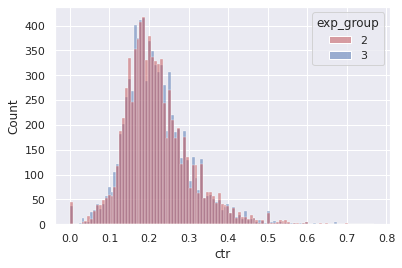

In [4]:
# Сделаем графики в seaborn для сравнения распределения ctr обеих групп
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df1, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [5]:
# выделяю в отдельный датафрейм user_id в группе №2
group_2 = df1[df1['exp_group'] == 2]
print(group_2)

       exp_group  user_id  likes  views       ctr
3              2   131473     19     98  0.193878
4              2    23985     12     44  0.272727
5              2    24523      2     10  0.200000
6              2    24239     10     41  0.243902
8              2   127588     14     87  0.160920
...          ...      ...    ...    ...       ...
16780          2    25071      5     15  0.333333
16781          2    17146     23    194  0.118557
16783          2    25383      2     18  0.111111
16785          2   108927     16     51  0.313725
16786          2    17310     24     75  0.320000

[8362 rows x 5 columns]


In [6]:
# выделяю в отдельный датафрейм user_id в группе №3
group_3 = df1[df1['exp_group'] == 3]
print(group_3)

       exp_group  user_id  likes  views       ctr
0              3   115383     38    248  0.153226
1              3    10326     24    132  0.181818
2              3   123580     25    122  0.204918
7              3    19647      4     31  0.129032
12             3   107670     17     94  0.180851
...          ...      ...    ...    ...       ...
16774          3   122758     18     85  0.211765
16777          3    13781      6     35  0.171429
16778          3   130651     10     75  0.133333
16782          3   122008     20    123  0.162602
16784          3   122190     15     56  0.267857

[8425 rows x 5 columns]


<Axes: ylabel='Count'>

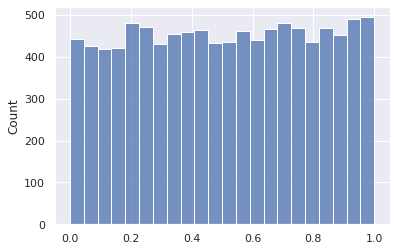

In [7]:
 pvalues = []

for i in range(10000):
    i, pvalue = stats.ttest_ind(group_2.ctr.sample(500, replace = False),
                             group_3.ctr.sample(500, replace = False),
                                                    equal_var=False)
    pvalues.append(pvalue)

sns.histplot(pvalues)

In [8]:
 alpha = 0.05

sum(float(num) <= alpha for num in pvalues) / len(pvalues) 

0.0487

По результату расчета 0,0487 всех  p-values оказался меньше либо равен 0.05, что говорит о том, что выборки могут отличаться с вероятностью 0,0468 , что меньшн 0,05 уровня значимости, принятого нами. 
Не оснований отклонить нулевую гипотезу.